# Plotting a time series (I)

In [ ]:
# Plot the time series in each dataset
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
data.iloc[:1000].plot(x='time', y='data_values', ax=axs[0])
data2.iloc[:1000].plot(x='time', y='data_values', ax=axs[1])
plt.show()

# Inspecting the classification data

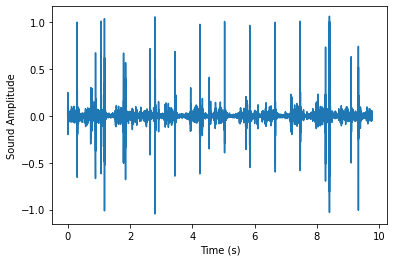

In [89]:
import librosa as lr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/home/pitu/Documents/jupyter/data/audio/archive/set_b'
# List all the wav files in the folder
audio_files = glob(data_dir + '/*.wav')

# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

# Inspecting the regression data

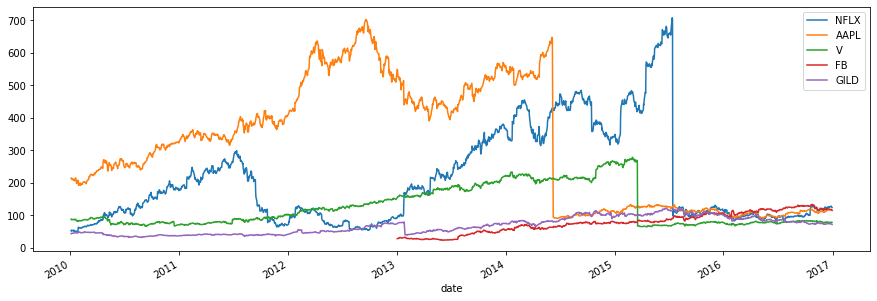

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
# Read in the data
data = pd.read_csv('/home/pitu/Documents/jupyter/data/prices/prices.csv', index_col=0)

# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)

# Loop through each column, plot its values over time
fig, ax = plt.subplots(figsize=(15, 5))
for stk in data.sort_values(by=['close'],ascending=False).symbol.unique()[:5]:
    data[data['symbol'] == stk]['close'].plot(ax=ax, label=stk)
ax.legend()
plt.show()

# Many repetitions of sounds

In [74]:
 audio_normal_1, sfreq_normal_1 = lr.load(audio_files[452])
 audio_normal_2, sfreq_normal_2 = lr.load(audio_files[453])
 audio_normal_3, sfreq_normal_3 = lr.load(audio_files[455])
 audio_abnormal_1, sfreq_abnormal_1 = lr.load(audio_files[448])
 audio_abnormal_2, sfreq_abnormal_2 = lr.load(audio_files[450])
 audio_abnormal_3, sfreq_abnormal_3 = lr.load(audio_files[454])

 min_length = min(len(audio_normal_1),len(audio_normal_2),len(audio_normal_3),len(audio_abnormal_1),len(audio_abnormal_2),len(audio_abnormal_3))
 sfreq = 22050

normal = np.hstack([np.asarray(audio_normal_1[:min_length]).reshape(-1,1), np.asarray(audio_normal_1[:min_length]).reshape(-1,1),np.asarray(audio_normal_3[:min_length]).reshape(-1,1)])

abnormal = np.hstack([np.asarray(audio_abnormal_1[:min_length]).reshape(-1,1), np.asarray(audio_abnormal_1[:min_length]).reshape(-1,1),np.asarray(audio_abnormal_3[:min_length]).reshape(-1,1)])

df_normal = pd.DataFrame(data=normal,columns=['normal_1','normal_2','normal_3'])
df_abnormal = pd.DataFrame(data=abnormal,columns=['abnormal_1','abnormal_2','abnormal_3'])

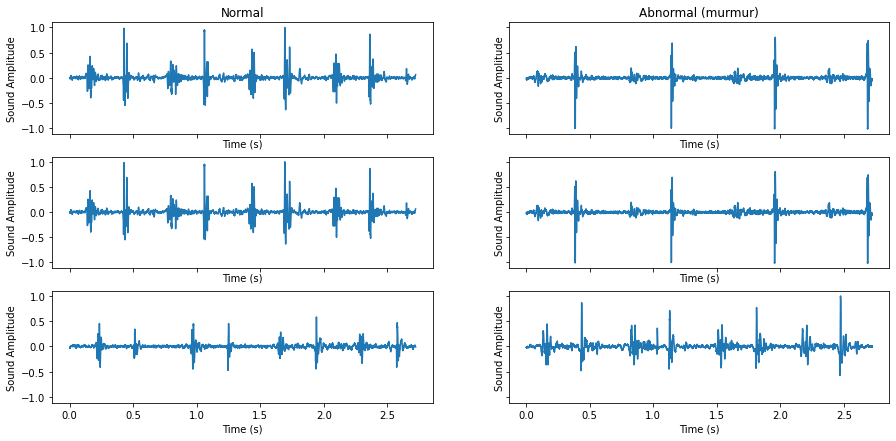

In [83]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(df_normal.shape[0]) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([df_normal, df_abnormal]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
    ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')

cols = ['Normal','Abnormal (murmur)']
for ax, col in zip(axs[0], cols):
    ax.set_title(col)
plt.show()
#show_plot_and_make_titles()

# Invariance in time

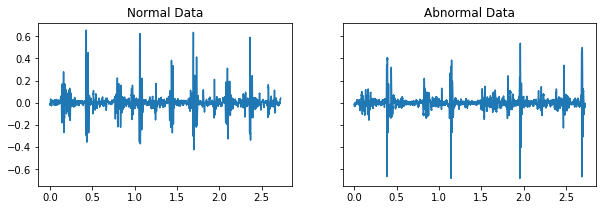

In [85]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(df_normal, axis=1)
mean_abnormal = np.mean(df_abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

# Build a classification model
In this exercise, you will use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict abnormal vs. normal heartbeats using only the raw data.

In [ ]:
from sklearn.svm import LinearSVC

# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

# Calculating the envelope of sound

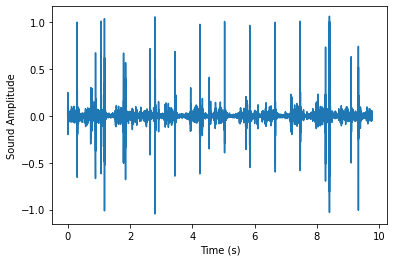

In [91]:
# Plot the raw data first
# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

## Calculating features from the envelope

In [ ]:
#window_size = 50
#windowed = audio.rolling(window=window_size)
#audio_smooth = windowed.mean()

audio_rectified = audio.apply(np.abs)
audio_envelope = audio_rectified.rolling(50).mean()

# Calculate stats
envelope_mean = np.mean(audio_envelope, axis=0)
envelope_std = np.std(audio_envelope, axis=0)
envelope_max = np.max(audio_envelope, axis=0)

# Create the X and y arrays
X = np.column_stack([envelope_mean, envelope_std, envelope_max])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
from sklearn.model_selection import cross_val_score
percent_score = cross_val_score(model, , y, cv=5)
print(np.mean(percent_score))

## Derivative features: The tempogram

In [ ]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

# Spectrograms of heartbeat audio


In [92]:
# Import the functions you'll use for the STFT
from librosa.core import stft

# Prepare the STFT
HOP_LENGTH = 2**4
spec = stft(audio, hop_length=HOP_LENGTH, n_fft=2**7)

# Engineering spectral features

In [93]:
import librosa as lr

# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
centroids = lr.feature.spectral_centroid(S=spec)[0]

ParameterError: Spectral bandwidth is only defined with real-valued input

# Combining many features in a classifier

In [ ]:
# Loop through each spectrogram
bandwidths = []
centroids = []

for spec in spectrograms:
    # Calculate the mean spectral bandwidth
    this_mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S=spec))
    # Calculate the mean spectral centroid
    this_mean_centroid = np.mean(lr.feature.spectral_centroid(S=spec))
    # Collect the values
    bandwidths.append(this_mean_bandwidth)  
    centroids.append(this_mean_centroid)